<a href="https://www.kaggle.com/code/yutodennou/preprocessing-categorical-data-control?scriptVersionId=175184612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

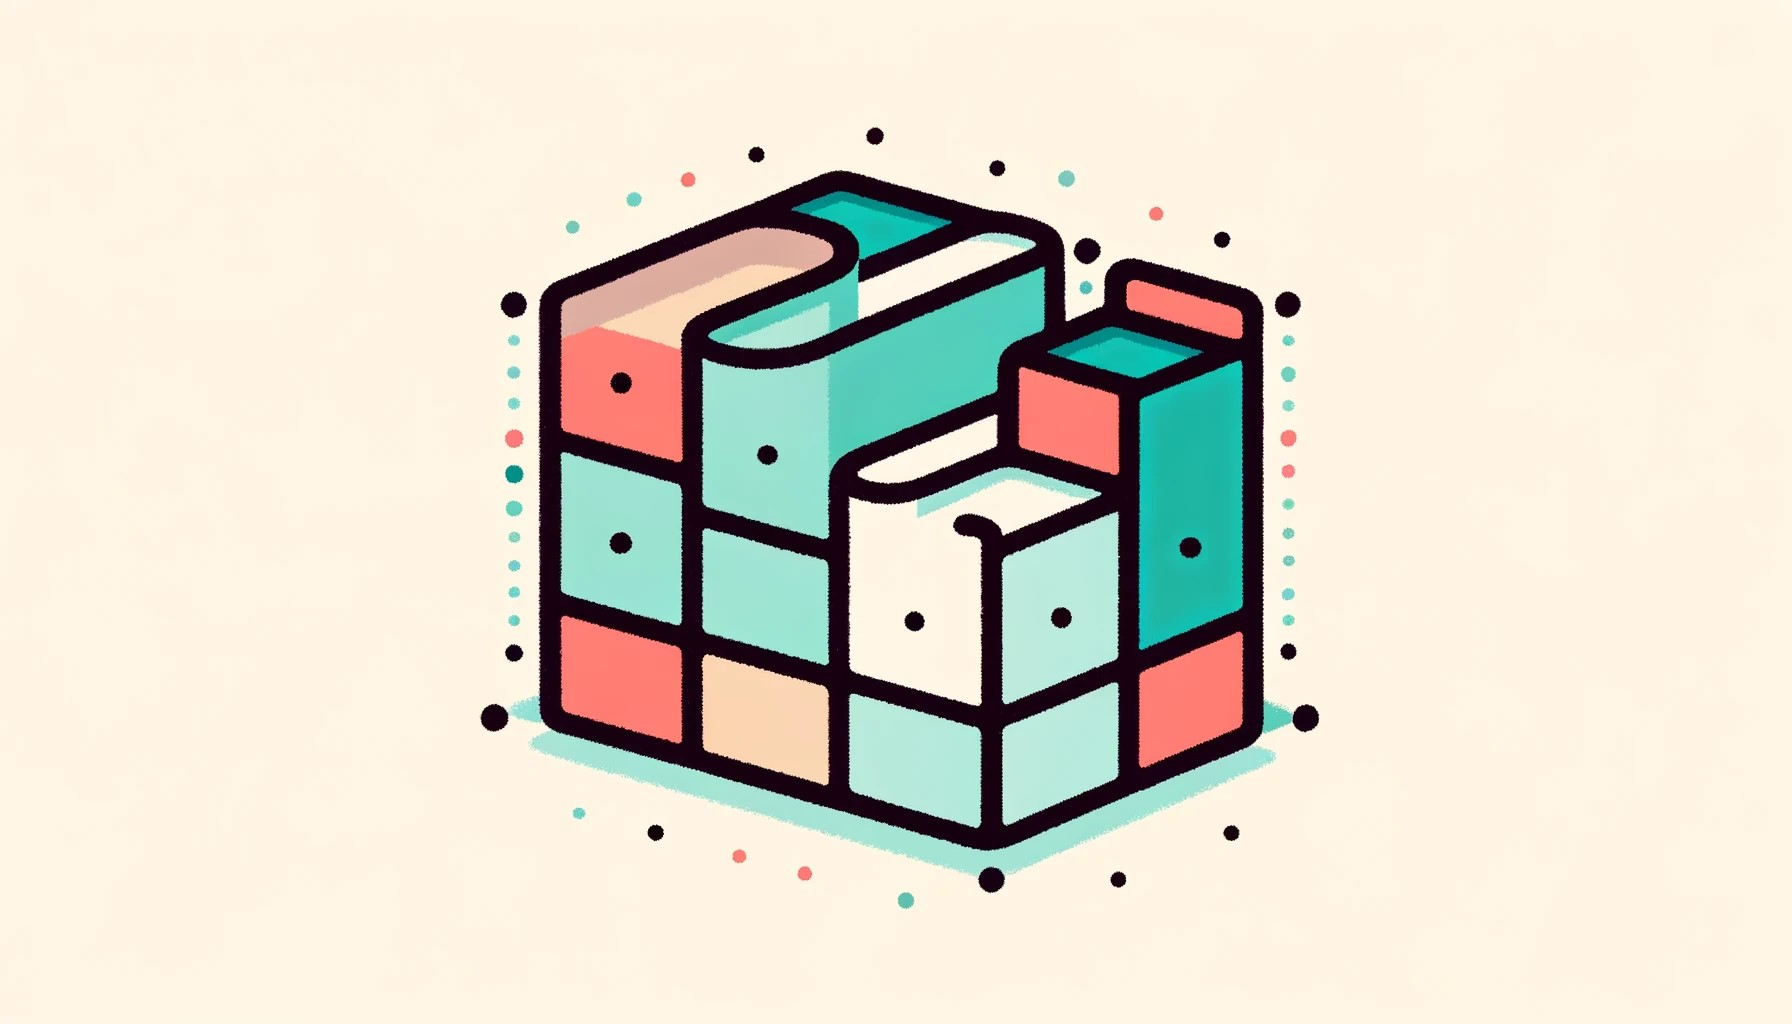
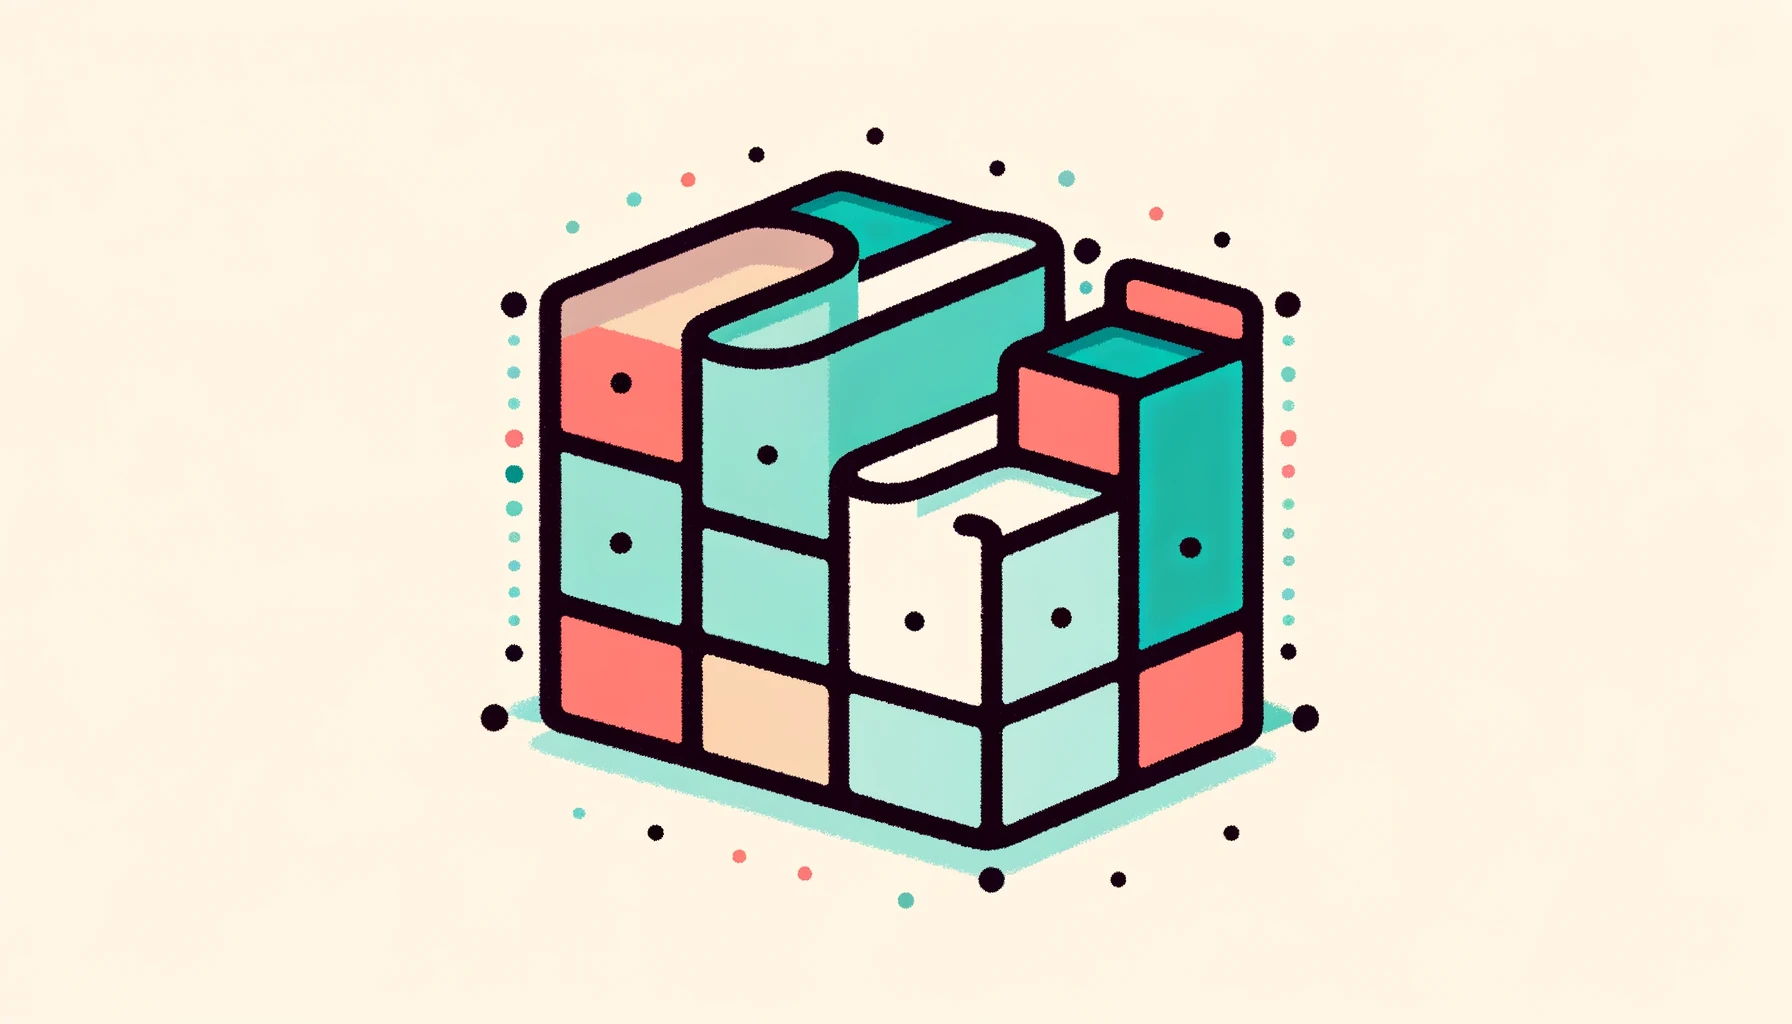

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 1. Purpose🎉 </b></div>

**This notebook explain that to resolve the problem that the number of columns does not match when Train data and Valid(even Test) data are coverted into binary columns by one-hot encodingmade.**

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 2. Preparation⚙️</b></div>


**You don't need to read these preparatuion codes below.
Just RUN to the next chapter!!**

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [4]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [6]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [8]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [9]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_valid = X_valid.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_train.mode().iloc[0])

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 3. Processing👉</b></div>


### Check the data structure 📝

In [10]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")

Train: (915995, 48)
Valid: (305332, 48)


They have the same number of columns, which is 48.

In [11]:
print(X_train.dtypes)
X_train.head(10)

amtinstpaidbefduel24m_4187115A      float64
annuity_780A                        float64
annuitynextmonth_57A                float64
avginstallast24m_3658937A           float64
avglnamtstart24m_4525187A           float64
avgoutstandbalancel6m_4187114A      float64
avgpmtlast12m_4525200A              float64
credamount_770A                     float64
currdebt_22A                        float64
currdebtcredtyperange_828A          float64
disbursedcredamount_1113A           float64
downpmt_116A                        float64
inittransactionamount_650A          float64
lastapprcommoditycat_1041M         category
lastapprcommoditytypec_5251766M    category
lastapprcredamount_781A             float64
lastcancelreason_561M              category
lastotherinc_902A                   float64
lastotherlnsexpense_631A            float64
lastrejectcommoditycat_161M        category
lastrejectcommodtypec_5251769M     category
lastrejectcredamount_222A           float64
lastrejectreason_759M           

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0.0,1917.6,0.0,800.0,100000.0,0.0,0.0,30000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
1,0.0,4937.0,0.0,800.0,100000.0,0.0,0.0,78000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
2,0.0,3600.0,0.0,800.0,100000.0,0.0,0.0,60000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
3,0.0,3110.8,0.0,800.0,100000.0,0.0,0.0,20000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
4,0.0,1218.0,0.0,800.0,100000.0,0.0,0.0,20300.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
5,0.0,8254.8,0.0,800.0,100000.0,0.0,0.0,40000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
6,0.0,5215.2,0.0,800.0,100000.0,0.0,0.0,40000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
7,0.0,2484.8,0.0,4178.0,100000.0,0.0,0.0,20000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
8,0.0,2436.0,0.0,800.0,100000.0,0.0,0.0,40600.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
9,0.0,2645.8,0.0,800.0,100000.0,0.0,0.0,14000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0


In [12]:
print(X_valid.dtypes)
X_valid.head(10)

amtinstpaidbefduel24m_4187115A      float64
annuity_780A                        float64
annuitynextmonth_57A                float64
avginstallast24m_3658937A           float64
avglnamtstart24m_4525187A           float64
avgoutstandbalancel6m_4187114A      float64
avgpmtlast12m_4525200A              float64
credamount_770A                     float64
currdebt_22A                        float64
currdebtcredtyperange_828A          float64
disbursedcredamount_1113A           float64
downpmt_116A                        float64
inittransactionamount_650A          float64
lastapprcommoditycat_1041M         category
lastapprcommoditytypec_5251766M    category
lastapprcredamount_781A             float64
lastcancelreason_561M              category
lastotherinc_902A                   float64
lastotherlnsexpense_631A            float64
lastrejectcommoditycat_161M        category
lastrejectcommodtypec_5251769M     category
lastrejectcredamount_222A           float64
lastrejectreason_759M           

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0.0,3134.0000,0.0000,800.0000,100000.0,0.0,0.0,19999.8,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
1,0.0,4643.6000,0.0000,800.0000,100000.0,0.0,0.0,40000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
2,0.0,4929.4000,0.0000,800.0000,100000.0,0.0,0.0,64000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
3,0.0,4471.0000,0.0000,800.0000,100000.0,0.0,0.0,70000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
4,0.0,3794.2000,0.0000,800.0000,100000.0,0.0,0.0,44000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
5,0.0,6191.0000,0.0000,800.0000,100000.0,0.0,0.0,30000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
6,0.0,3253.4001,0.0000,800.0000,100000.0,0.0,0.0,34000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
7,0.0,6000.0000,3979.4001,3979.4001,100000.0,0.0,0.0,100000.0,35748.6,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
8,0.0,5180.2000,0.0000,800.0000,100000.0,0.0,0.0,60000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0
9,0.0,4582.2000,0.0000,800.0000,100000.0,0.0,0.0,44000.0,0.0,0.0,...,600.0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,0.0,7222.2,2833.4001,0.0


Many categorical variables that are needed to covert into binary columns by one-hot encoding

In [13]:
set(X_train.columns) ^ set(X_valid.columns)

set()

### When using `get_dummies` 😼

In [14]:
X_train_tmp = pd.get_dummies(X_train)
X_valid_tmp = pd.get_dummies(X_valid)

In [15]:
X_train_tmp.head(10)

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,maritalst_385M_b6cabe76,maritalst_385M_ecd83604,maritalst_385M_Unknown,maritalst_893M_1a19667c,maritalst_893M_46b968c3,maritalst_893M_977b2a70,maritalst_893M_a55475b1,maritalst_893M_e18430ff,maritalst_893M_ecd83604,maritalst_893M_Unknown
0,0.0,1917.6,0.0,800.0,100000.0,0.0,0.0,30000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
1,0.0,4937.0,0.0,800.0,100000.0,0.0,0.0,78000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
2,0.0,3600.0,0.0,800.0,100000.0,0.0,0.0,60000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
3,0.0,3110.8,0.0,800.0,100000.0,0.0,0.0,20000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
4,0.0,1218.0,0.0,800.0,100000.0,0.0,0.0,20300.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
5,0.0,8254.8,0.0,800.0,100000.0,0.0,0.0,40000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
6,0.0,5215.2,0.0,800.0,100000.0,0.0,0.0,40000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
7,0.0,2484.8,0.0,4178.0,100000.0,0.0,0.0,20000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
8,0.0,2436.0,0.0,800.0,100000.0,0.0,0.0,40600.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
9,0.0,2645.8,0.0,800.0,100000.0,0.0,0.0,14000.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False


### Problem!!🙅‍♂️

In [16]:
print(f"Train: {X_train_tmp.shape}")
print(f"Valid: {X_valid_tmp.shape}")

Train: (915995, 834)
Valid: (305332, 736)


The number of columns are different between Train data and Valid data due to the different number of unique values of categorical variables.
- Train data has 834 columns 
- Valid data has 736 columns

In [17]:
print("Unique columns that train data has but valid data doesn't has:" )
print(len(set(X_train_tmp.columns) - set(X_valid_tmp.columns)))

print("Unique columns that valid data has but train data doesn't has:" )
len(set(X_valid_tmp.columns) - set(X_train_tmp.columns))

Unique columns that train data has but valid data doesn't has:
133
Unique columns that valid data has but train data doesn't has:


35

`834-736 = 98` and also `133-35 = 98`.
Train and valid data have unique columns each other and the differences are 98.

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 4. Solution🙆‍♂️</b></div>


### Using `pd.CategoricalDtype` to set all unique categorical values into each column

In [19]:
X_train.iloc[0]

amtinstpaidbefduel24m_4187115A           0.0
annuity_780A                          1917.6
annuitynextmonth_57A                     0.0
avginstallast24m_3658937A              800.0
avglnamtstart24m_4525187A           100000.0
avgoutstandbalancel6m_4187114A           0.0
avgpmtlast12m_4525200A                   0.0
credamount_770A                      30000.0
currdebt_22A                             0.0
currdebtcredtyperange_828A               0.0
disbursedcredamount_1113A            30000.0
downpmt_116A                             0.0
inittransactionamount_650A               0.0
lastapprcommoditycat_1041M          a55475b1
lastapprcommoditytypec_5251766M     a55475b1
lastapprcredamount_781A                  0.0
lastcancelreason_561M               a55475b1
lastotherinc_902A                        0.2
lastotherlnsexpense_631A                 0.0
lastrejectcommoditycat_161M         a55475b1
lastrejectcommodtypec_5251769M      a55475b1
lastrejectcredamount_222A           100000.0
lastreject

In [23]:
X_train.loc[:, X_train.iloc[0].map(type) == str]

,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastcancelreason_561M,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectreason_759M,lastrejectreasonclient_4145040M,previouscontdistrict_112M,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M
0,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
2,a55475b1,a55475b1,P85_114_140,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
3,a55475b1,a55475b1,P94_109_143,a55475b1,a55475b1,P94_109_143,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
4,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915990,a55475b1,a55475b1,P94_109_143,a55475b1,a55475b1,P45_84_106,P94_109_143,P65_13_8,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1
915991,P12_6_178,P142_50_170,a55475b1,a55475b1,a55475b1,P94_109_143,P94_109_143,P123_39_170,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1
915992,P159_130_59,P75_90_70,P180_60_137,a55475b1,a55475b1,a55475b1,a55475b1,P133_44_167,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1
915993,a55475b1,a55475b1,a55475b1,P159_130_59,P174_113_42,a55475b1,a55475b1,P123_6_84,2fc785b2,6b2ae0fa,a55475b1,3439d993,a55475b1


In [24]:
cols = X_train.loc[:, X_train.iloc[0].map(type) == str].columns.unique()
print('Categorical columns:')
print(cols)

Categorical columns:
Index(['lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M',
       'lastcancelreason_561M', 'lastrejectcommoditycat_161M',
       'lastrejectcommodtypec_5251769M', 'lastrejectreason_759M',
       'lastrejectreasonclient_4145040M', 'previouscontdistrict_112M',
       'description_5085714M', 'education_1103M', 'education_88M',
       'maritalst_385M', 'maritalst_893M'],
      dtype='object')


In [25]:
for col in cols:
    cat_list = {*X_train[col], *X_valid[col]}
    X_train[col] = X_train[col].astype(pd.CategoricalDtype(cat_list))
    X_valid[col] = X_valid[col].astype(pd.CategoricalDtype(cat_list))

`cat_list` has unique value of each column from both Train and Valid.

In [55]:
print(X_train[col])

0         a55475b1
1         a55475b1
2         a55475b1
3         a55475b1
4         a55475b1
            ...   
915990    a55475b1
915991    a55475b1
915992    a55475b1
915993    a55475b1
915994    a55475b1
Name: maritalst_893M, Length: 915995, dtype: category
Categories (6, object): ['a55475b1', '1a19667c', '977b2a70', '46b968c3', 'ecd83604', 'e18430ff']


In [28]:
X_train_tmp = pd.get_dummies(X_train)
X_valid_tmp = pd.get_dummies(X_valid)

In [29]:
print(f"Train: {X_train_tmp.shape}")
print(f"Valid: {X_valid_tmp.shape}")

Train: (915995, 856)
Valid: (305332, 856)


### The number of Valid data columns is as same as that of Test data!!👍

### Thank you for check my notebook and also follow my SNS😊

[![Github](https://img.shields.io/badge/--FFFFFF?style=social&logo=github&label=Follow%20yutowac)](https://github.com/yutowac)


[![LinkedIn](https://img.shields.io/badge/--FFFFFF?style=social&logo=LinkedIn&label=Follow%20yutowac)](https://www.linkedin.com/in/wachi-yuto-b43ab3a2/)